#Installing Required Python Modules

##PIP Install
Pip è il manager dei pacchetti di Python



In [ ]:
!pip install pycocotools #input dalla webcam
!pip install ffmpeg #salvare immagini

#Mount Drive and define work directory

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

In [ ]:
import os
work_dir = "/content/drive/My Drive/SKILLIT Courses/AI Level 2/Final Project"
os.chdir(work_dir)

#Imports

In [ ]:
from colab_utils import imshow, videoGrabber
import numpy as np
import matplotlib.pyplot as plt
from google.colab import output       #per ripulire / non affastellare schermo

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tqdm.auto import tqdm            #status bar (barra di progresso)

#Define Classes


In [ ]:
CLASS_NAME = ['Paper', 'Rock', 'Scissor']

#Define image capture function


In [ ]:
def capture_images(numImage=50,label='Null'): #cattura 50 immagini

  vid = videoGrabber(showVideo=True,size = (224,224)) #dimensione richiesta dal pre-made model scaricato
  img=[]
  y = []

  for x in tqdm(range(numImage)):
    new_image = np.array(vid(0))
    img.append(new_image)
    if label!='Null':
      y.append(label)
  img = np.array(img)
  y = np.array(y)
  return img,y


#Give Dataset


In [ ]:
paper_images, paper_label = capture_images(numImage=100,label=0) #vengono prese immagini di riferimento su cui modello si allenerà da webcam

In [ ]:
rock_images, rock_label = capture_images(numImage=100,label=1)

In [ ]:
scissor_images, scissor_label = capture_images(numImage=100,label=2)

In [ ]:
train_images = np.concatenate((paper_images,rock_images,scissor_images))  #le 3 classi vengono combinate
train_images = train_images/255
train_labels = np.concatenate((paper_label,rock_label,scissor_label))

#Generating more dataset

Servono più immagini per un allenamento efficace



In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# creiamo oggetto "data generator" che crea immagini trasformate da quelle di partenza
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

idx = 0
new_train_images = []
new_train_labels = []
for image in train_images:
  img = image.reshape((1,)+image.shape)   #rende l'immagine 3D (1,244, 244)
  i=0
  for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):
      plot = plt.imshow(batch[0])
      i += 1
      new_train_images.append(batch[0])
      new_train_labels.append(train_labels[idx])
      if i > 10:
          break #unico modo interrompere questo for
  idx+=1

plt.show()

In [ ]:
new_train_images = np.array(new_train_images)
new_train_labels = np.array(new_train_labels)

#Using a pretrained model


In [ ]:
IMG_SHAPE= (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

In [ ]:
base_model.summary()

##Freezing the Base


In [ ]:
base_model.trainable = False #non più allenabile, non vogliamo cambiare base convoluzionale già allenata

In [ ]:
base_model.summary() #verifichiamo che in fondo variabili non siano più allenabili

#Adding the normal neural network at the end of CNN


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() #area 7x7 diventa vettore di 1280 elementi

In [ ]:
prediction_layer = tf.keras.layers.Dense(3)

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
]) #combiniamo tutto insieme nel modello sequenziale

In [ ]:
model.summary()

#Train the model


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(new_train_images,new_train_labels,epochs=10) #10 fasi di allenamento

#Output Calculation


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Text(0.5, 1.0, 'Paper')

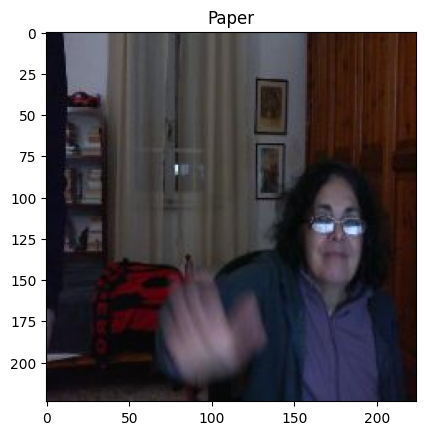

In [ ]:
test_image, _= capture_images(1)

test_image = test_image/255
prediction = model.predict(test_image)
plt.imshow(test_image[0])
plt.title(CLASS_NAME[np.argmax(prediction[0])])

#Saving the Model
We're using the basic save method given in **Tensorflow.Keras** to save our model. So, we're going to name it as **pre-made_model.h5** h5 being the standard extension for saving Tensorflow models

In [ ]:
model_save_path = os.path.join(work_dir,'premade_dir')
model.save('pre-made_model.h5')